In [1]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Process, Queue, Array
import time

In [2]:
def dh(shape,arr,i,j,dq=None):
    if MODEL =="SPINS1":
     return G.dh(arr,i,j)   
    y,x = shape
    d=arr[i-1][j]
    u=arr[(i+1)%y][j]
    l=arr[i][j-1]
    r=arr[i][(j+1)%x]
    if MODEL=="ISING1":
        return arr[i][j]*(d+u+l+r)*2
    if MODEL=="POTTS1":
        intl = np.asarray([d,u,l,r])-(arr[i][j])
        aftr = np.asarray([d,u,l,r])-(arr[i][j]+dq)%Q
        return np.sum(np.cos(intl*2*np.pi/Q))-np.sum(np.cos(aftr*2*np.pi/Q))
def flipsite(shape):
    """Spin flip where a random spin in the grid is changed (Potts is still an integer representation)"""
    x,y = shape
    x_ = np.random.randint(0,x)
    y_ = np.random.randint(0,y)
    if MODEL!="POTTS1":
        return x_,y_
    else:
        return x_,y_,np.random.randint(1,Q)
def metropolis(x,y,T,iterate = 2500):
   """Runs a monte carlo simulation with the specified hamiltonian function H"""
   C = np.e**(-1.0/(KB*T))
   arr = domain(x,y)
   shape=np.shape(arr)
   size=np.prod(shape)
   m= np.sum(arr)//2+size//2
   ms = np.zeros([size+1],dtype=np.int32)
   ms[m]=1
   for i in range(iterate):
       site=flipsite(shape)
       dH = dh(shape,arr,*site)
       n=np.random.random()
       if dH <=0 or n < C**dH:
           if MODEL=="POTTS1":
                arr[site[0]][site[1]]=(arr[site[0]][site[1]]+site[2])%Q
           else:
               arr[site[0]][site[1]]*=-1
           m+= arr[site[0]][site[1]]
       if i>2*iterate//5:
           ms[m]=ms[m]+1
   return ms
def errspinsQueue(num1,num2,div,steps,q):
   #np.random.seed(seed)
   steps = int(steps)
   q.put("INIT: %d-%d"%(num1,num2))
   x = [z/div for z in range(num1,num2)]
   res = [x,[],[]]
   for a in x :
       eq = metropolis(N,N,a,steps)
       n=np.sum(eq)
       avg = np.sum([abs(i-N**2//2)*eq[i] for i in range(len(eq))])/n
       st_dv = np.power(np.sum([eq[i]*(abs(i-N**2//2)-avg)**2 for i in range(len(eq))])/n,0.5)
       res[1]+=[avg]
       res[2]+=[st_dv]
       q.put(str(a))
   q.put(res)
def transition(start,end,div,seed,cores=4,steps=1e6):
   global q,ps
   np.random.seed(seed)
   print("Begin")
   q = Queue()
   ps = []
   for idx in range(cores):
       delta = end-start
       st = start+(delta*idx//cores)
       ed = start+(delta*(idx+1)//cores)
       ps +=  [Process(target=errspinsQueue, args=(st,ed,div,steps,q))]
   print("made")
   for p in ps:
       p.start()
   print("started")
   li = []
   while len(li) < cores:
       n = q.get()
       if type(n)!= str:
           li += [n]
           print('recieved!')
       else:
           print (n,end = " ")
   for p in ps:
       p.join()
   L = [[],[],[],seed]
   for l in li:
       L[0]+=l[0]
       L[1]+=l[1]
       L[2]+=l[2]
   print(L)
   errplt(*L)
   return L


In [2]:
def metropolis(x,y,T,H,iterate = 2500):
    """Runs a monte carlo simulation with the specified hamiltonian function H"""
    m = []
    C = np.e**(-1.0/(KB*T))
    arr = domain(x,y)
    Hi = H(arr)
    m+= [metric(arr)]
    for i in range(iterate):
        arr2 = augment(arr)
        Hf = H(arr2)
        dH = Hf-Hi
        n=np.random.random()
        if dH <=0 or n < C**dH:
            Hi = Hf
            arr = arr2
            m+= [metric(arr)]
        else:
            m+=[m[-1]]
    return m
def errspinsQueue(num1,num2,div,steps,q,hamiltonian):
    #np.random.seed(seed)
    steps = int(steps)
    q.put("INIT: %d-%d"%(num1,num2))
    x = [z/div for z in range(num1,num2)]
    res = [x,[],[]]
    for a in x :
        n = metropolis(N,N,a,hamiltonian,steps)
        eq = n[-steps//5:]
        avg = np.sum(eq)/len(eq)
        st_dv = np.power(np.sum([(x-avg)**2 for x in eq])/len(eq),0.5)
        res[1]+=[avg]
        res[2]+=[st_dv]
        q.put(str(a))
    q.put(res)

def transition(start,end,div,seed,cores=4,steps=1e6,hamiltonian=H):
    np.random.seed(seed)
    print("Begin")
    q = Queue()
    ps = []
    for idx in range(cores):
        delta = end-start
        st = start+(delta*idx//cores)
        ed = start+(delta*(idx+1)//cores)
        ps +=  [Process(target=errspinsQueue, args=(st,ed,div,steps,q,hamiltonian))]
    print("made")
    for p in ps:
        p.start()
    print("started")
    li = []
    while len(li) < cores:
        n = q.get() 
        if type(n)!= str:
            li += [n]
            print('recieved!')
        else:
            print (n,end = " ")
    for p in ps:
        p.join()
    L = [[],[],[]]
    for l in li:
        L[0]+=l[0]
        L[1]+=l[1]
        L[2]+=l[2]
    order = sorted([a for a in range(len(L[0]))], key = lambda x: L[0][x])
    L = [[L[i][x] for x in order] for i in [0,1,2]]+[seed]
    print(L)
    errplt(*L)
    plt.show()
    return L


In [3]:
def errplt(in_,out,errs,seed,style = "error",ylabel="avg spin",**kwargs):
    if style=="error":
        plt.errorbar(in_, out, errs, linestyle='None', marker='.',**kwargs)
    elif style == "dot":
        plt.plot(in_,out,"o",**kwargs)
    else:
        plt.plot(in_,out,**kwargs)
    plt.ylabel(ylabel)
    plt.xlabel("temperature °K [seed:%d]"%seed)
def in_(string):
   x = [[],[],[]]
   for a in string.split("\n"):
       a=a.split("\t")
       x[0]+=[float(a[0])]
       x[1]+=[float(a[1])]
       x[2]+=[float(a[2])]
   return x
def output(a):
 string = ""
 for i in range(len(a[0])):
   str_="%f\t%f\t%f"%(a[0][i],a[1][i],a[2][i])
   print(str_)
   string+=str_+"\n"
 return string[:-1]

In [ ]:
t = time.time()
tr = transition(5,49,10,33,cores=8,steps=1e4)
dt = (time.time()-t)
#output(tr)
print("%d:%d"%(dt//60,int(dt)-60*(dt//60)))
def big_graph(runs):
    assert runs>=1
    t = time.time()
    for seed in range(runs):
      ordered =transition(5,49,10,seed,cores=8,steps=1e6)[:-1]
      if seed==0:
        AVGS = np.asarray(ordered)
      else:
        AVGS+=np.asarray(ordered)
    AVGS/=runs
    print("%d:%d"%(dt//60,int(dt)-60*(dt//60)))
    errplt(AVGS[0],AVGS[1],AVGS[2],0)
    output(AVGS)

Begin
made
started


Begin
made
started
INIT: 5-10 INIT: 10-16 INIT: 21-27 INIT: 16-21 INIT: 27-32 INIT: 38-43 INIT: 43-49 INIT: 32-38 0.5 1.0 1.6 2.1 3.2 2.7 4.3 3.8 0.6 1.7 1.1 2.2 2.8 3.3 3.9 4.4 1.2 1.8 0.7 2.3 2.9 3.4 4.0 4.5 1.3 0.8 1.9 2.4 3.0 3.5 4.1 4.6 1.4 0.9 recieved!
2.0 recieved!
2.5 3.1 recieved!
3.6 1.5 recieved!
4.2 recieved!
4.7 2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 0.999991328125, 0.999963515625, 0.9998041796875, 0.9996886328125, 0.9991445703125, 0.9983107421875, 0.9966191015625, 0.9947352734375, 0.991849296875, 0.9875412890625, 0.9807989453125, 0.971423203125, 0.9600209375, 0.9343705078125, 0.9241847265625, 0.882679609375, 0.7656529296875, 0.6943394140625, 0.50268765625, 0.3985987890625, 0.2507225, 0.2012678515625, 0.2502813671875, 0.1941551171875, 0.1870443

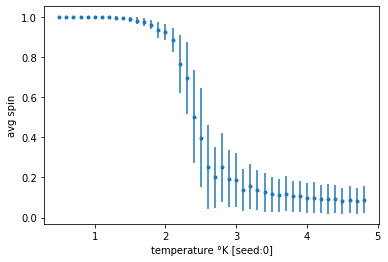

Begin
made
started
INIT: 5-10 INIT: 10-16 INIT: 16-21 INIT: 21-27 INIT: 27-32 INIT: 32-38 INIT: 43-49 INIT: 38-43 1.0 0.5 1.6 2.1 2.7 3.2 4.3 3.8 1.1 0.6 1.7 2.2 2.8 3.3 3.9 4.4 0.7 1.2 1.8 2.3 2.9 3.4 4.0 4.5 0.8 1.3 1.9 2.4 3.0 3.5 0.9 recieved!
1.4 4.1 2.0 recieved!
4.6 2.5 3.1 recieved!
1.5 recieved!
3.6 4.2 recieved!
4.7 2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 1.0, 0.999984609375, 0.9998459375, 0.99974328125, 0.9993884375, 0.99898796875, 0.996150234375, 0.9946142578125, 0.9909656640625, 0.986630703125, 0.9796519921875, 0.97222421875, 0.9512815625, 0.9412299609375, 0.9199762890625, 0.8774398046875, 0.8340275390625, 0.5914921875, 0.495793828125, 0.4058902734375, 0.3348048828125, 0.2362295703125, 0.2089921875, 0.20565578125, 0.17065078125, 0.15739484375, 0.

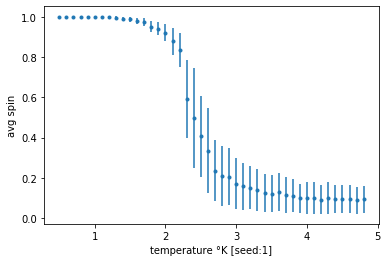

Begin
made
started
INIT: 5-10 INIT: 16-21 INIT: 21-27 INIT: 27-32 INIT: 10-16 INIT: 32-38 INIT: 38-43 INIT: 43-49 1.0 1.6 0.5 3.8 2.1 2.7 4.3 3.2 1.1 1.7 0.6 3.9 2.2 2.8 4.4 1.2 3.3 0.7 1.8 2.3 4.0 1.3 2.9 4.5 3.4 0.8 1.9 1.4 2.4 4.1 3.0 4.6 0.9 recieved!
3.5 2.0 recieved!
1.5 recieved!
2.5 4.2 recieved!
3.1 recieved!
4.7 3.6 2.6 recieved!
4.8 recieved!
3.7 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [0.2272193359375, 1.0, 0.99996953125, 0.999907578125, 0.999730234375, 0.9994018359375, 0.998547109375, 0.9973628515625, 0.994525234375, 0.9913595703125, 0.985650078125, 0.9817656640625, 0.9673796875, 0.961550234375, 0.9329507421875, 0.9195218359375, 0.8768778515625, 0.7884558984375, 0.56856203125, 0.513168671875, 0.332955078125, 0.2534496875, 0.2490508984375, 0.2312562109375, 0.15708375, 0.182845625, 0.1

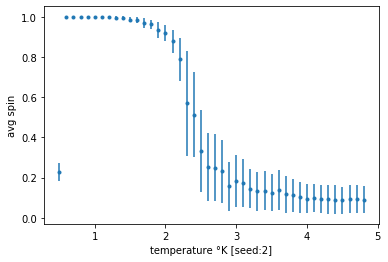

Begin
made
started
INIT: 5-10 INIT: 10-16 INIT: 16-21 INIT: 21-27 INIT: 32-38 INIT: 38-43 INIT: 43-49 INIT: 27-32 1.6 1.0 0.5 2.1 2.7 3.2 3.8 4.3 1.7 0.6 1.1 2.2 2.8 3.3 3.9 4.4 1.8 0.7 1.2 2.3 2.9 3.4 4.0 4.5 0.8 1.3 1.9 2.4 3.0 3.5 4.1 0.9 recieved!
1.4 2.0 recieved!
4.6 2.5 3.1 recieved!
1.5 recieved!
3.6 4.2 recieved!
4.7 2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [0.0092888671875, 1.0, 0.999982265625, 0.9999201953125, 0.9997068359375, 0.9994441796875, 0.99880921875, 0.997582265625, 0.994448828125, 0.991696796875, 0.9865508203125, 0.97890859375, 0.9703422265625, 0.9582555078125, 0.9391976171875, 0.917801484375, 0.8739527734375, 0.8280223046875, 0.7655223828125, 0.5539057421875, 0.413545625, 0.4079508984375, 0.3045340234375, 0.221521640625, 0.174607890625, 0.209780

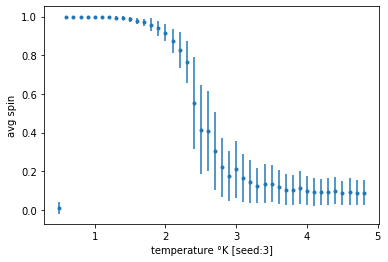

Begin
made
started
INIT: 5-10 INIT: 10-16 INIT: 16-21 INIT: 21-27 INIT: 27-32 INIT: 38-43 INIT: 32-38 INIT: 43-49 1.0 0.5 1.6 2.1 2.7 3.2 3.8 4.3 1.1 0.6 1.7 2.2 2.8 3.3 3.9 4.4 1.2 0.7 1.8 2.3 2.9 3.4 4.0 4.5 1.3 0.8 1.9 2.4 3.0 3.5 0.9 recieved!
4.1 1.4 4.6 2.0 recieved!
2.5 3.1 recieved!
3.6 1.5 recieved!
4.2 recieved!
4.7 2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 1.0, 0.999905859375, 0.9998773046875, 0.9996876953125, 0.9991759375, 0.9984815234375, 0.99687109375, 0.9950204296875, 0.9910601953125, 0.98703796875, 0.9783438671875, 0.968809765625, 0.959560078125, 0.9300925, 0.9162786328125, 0.8626471484375, 0.81357390625, 0.602351875, 0.494647890625, 0.388580703125, 0.281815546875, 0.2379082421875, 0.2199565625, 0.17691109375, 0.1563726171875, 0.1551758203125, 0

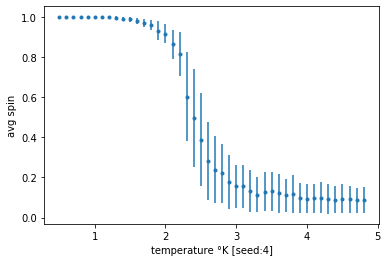

Begin
made
started
INIT: 10-16 INIT: 16-21 INIT: 32-38 INIT: 21-27 INIT: 5-10 INIT: 27-32 INIT: 38-43 INIT: 43-49 0.5 1.6 2.7 2.1 3.2 1.0 4.3 3.8 0.6 1.7 1.1 2.2 2.8 3.3 3.9 4.4 0.7 1.8 1.2 3.4 2.3 2.9 4.0 0.8 1.9 1.3 4.5 3.5 2.4 3.0 4.1 0.9 recieved!
1.4 2.0 recieved!
4.6 2.5 3.6 3.1 recieved!
1.5 recieved!
4.2 recieved!
4.7 2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 0.9999950390625, 0.9999883984375, 0.9999062890625, 0.99966171875, 0.9992328125, 0.9984101171875, 0.9971555859375, 0.994992890625, 0.9906905078125, 0.9864111328125, 0.9783095703125, 0.967541640625, 0.9593237109375, 0.9361660546875, 0.9120612890625, 0.869283984375, 0.79580234375, 0.781012734375, 0.4763373828125, 0.4619680859375, 0.3160319921875, 0.2581322265625, 0.1902580078125, 0.186129140625, 0.181

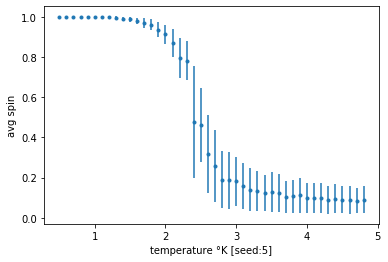

Begin
made
started
INIT: 16-21 INIT: 10-16 INIT: 21-27 INIT: 5-10 INIT: 27-32 INIT: 32-38 INIT: 38-43 INIT: 43-49 1.6 2.7 1.0 3.8 0.5 3.2 4.3 2.1 1.7 1.1 2.8 0.6 4.4 3.9 3.3 2.2 1.2 0.7 1.8 2.9 2.3 4.5 4.0 3.4 1.3 0.8 1.9 3.0 2.4 4.6 1.4 2.0 recieved!
3.5 4.1 0.9 recieved!
2.5 3.1 recieved!
1.5 recieved!
4.7 3.6 4.2 recieved!
2.6 recieved!
4.8 recieved!
3.7 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 1.0, 0.999979140625, 0.999903671875, 0.999711875, 0.9992961328125, 0.9985884765625, 0.9972569140625, 0.9953997265625, 0.99212265625, 0.98666375, 0.978903359375, 0.9711019921875, 0.955423203125, 0.939189296875, 0.9150829296875, 0.8914319140625, 0.746600625, 0.664896015625, 0.5024219921875, 0.3708623828125, 0.27790484375, 0.260222109375, 0.242345, 0.1788447265625, 0.1878852734375, 0.163167109375, 0.1

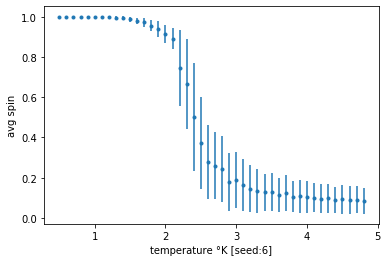

Begin
made
started
INIT: 5-10 INIT: 10-16 INIT: 16-21 INIT: 21-27 INIT: 27-32 INIT: 32-38 INIT: 38-43 INIT: 43-49 0.5 1.0 1.6 4.3 2.1 2.7 3.2 3.8 1.1 0.6 1.7 2.2 3.3 2.8 4.4 3.9 0.7 1.8 1.2 2.3 2.9 3.4 4.5 1.9 1.3 0.8 4.0 2.4 3.0 1.4 3.5 2.0 recieved!
0.9 recieved!
4.6 4.1 2.5 1.5 recieved!
3.1 recieved!
3.6 4.7 4.2 recieved!
2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 1.0, 0.99998796875, 0.999932578125, 0.99969703125, 0.9992795703125, 0.998224140625, 0.9969855859375, 0.9952696484375, 0.9916903515625, 0.9872448046875, 0.9811342578125, 0.96933578125, 0.95741546875, 0.937411015625, 0.913075234375, 0.867973125, 0.7945468359375, 0.6379710546875, 0.6109262109375, 0.3239992578125, 0.3301401171875, 0.29601890625, 0.2063224609375, 0.19024671875, 0.1549275, 0.161625273437

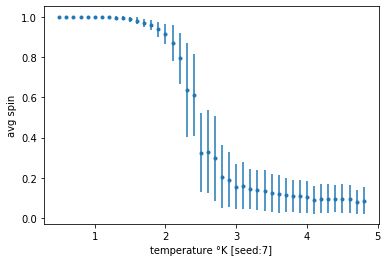

Begin
made
started
INIT: 10-16 INIT: 5-10 INIT: 16-21 INIT: 27-32 INIT: 32-38 INIT: 21-27 INIT: 38-43 INIT: 43-49 0.5 1.0 2.1 1.6 3.2 3.8 2.7 4.3 0.6 1.7 1.1 2.2 3.3 4.4 2.8 3.9 0.7 1.8 2.3 1.2 3.4 4.5 2.9 4.0 0.8 1.9 1.3 2.4 3.5 4.6 2.0 recieved!
3.0 4.1 0.9 recieved!
1.4 2.5 3.6 4.7 1.5 recieved!
3.1 recieved!
4.2 recieved!
2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [0.185401171875, 1.0, 0.99999859375, 0.9998628125, 0.9997576171875, 0.999370625, 0.9986001171875, 0.9968890625, 0.994804375, 0.9910604296875, 0.9861360546875, 0.9787867578125, 0.9699525, 0.9558259765625, 0.938345078125, 0.9107895703125, 0.8890321484375, 0.814037109375, 0.64363234375, 0.667250234375, 0.395299453125, 0.2636873828125, 0.229796484375, 0.221431328125, 0.1811840625, 0.1875883203125, 0.16240023

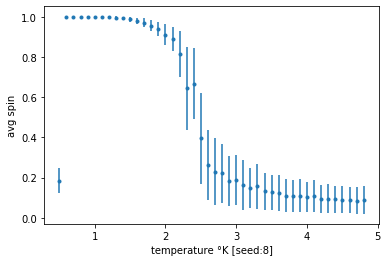

Begin
made
started
INIT: 10-16 INIT: 5-10 INIT: 16-21 INIT: 21-27 INIT: 27-32 INIT: 38-43 INIT: 32-38 INIT: 43-49 1.6 1.0 0.5 2.7 4.3 2.1 3.2 3.8 1.1 1.7 0.6 2.8 4.4 3.3 2.2 3.9 1.2 1.8 0.7 2.9 4.5 3.4 2.3 1.3 4.0 1.9 0.8 3.0 3.5 4.6 2.0 recieved!
2.4 0.9 recieved!
1.4 4.1 3.1 recieved!
3.6 2.5 1.5 recieved!
4.7 4.2 recieved!
2.6 recieved!
3.7 recieved!
4.8 recieved!
[[0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8], [1.0, 0.96834375, 0.9999992578125, 0.9999520703125, 0.9998176953125, 0.999544453125, 0.9984975390625, 0.99715234375, 0.9944898828125, 0.99117015625, 0.987275546875, 0.9794468359375, 0.969870625, 0.9596073046875, 0.9366656640625, 0.9059948046875, 0.8515298046875, 0.756206484375, 0.664962578125, 0.520178359375, 0.3625394140625, 0.32682640625, 0.2963701171875, 0.226513671875, 0.1983528515625, 0.155851171875

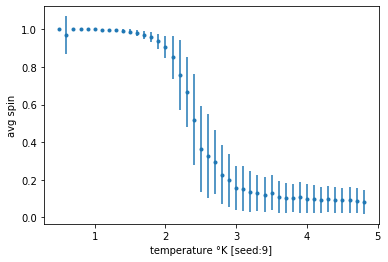

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [5]:
Q=2
MODEL="ISING1"
N=16
big_graph(10)